(100, 452, 452)


Text(0.5, 1.0, 'auto-corr, (452, 452)')

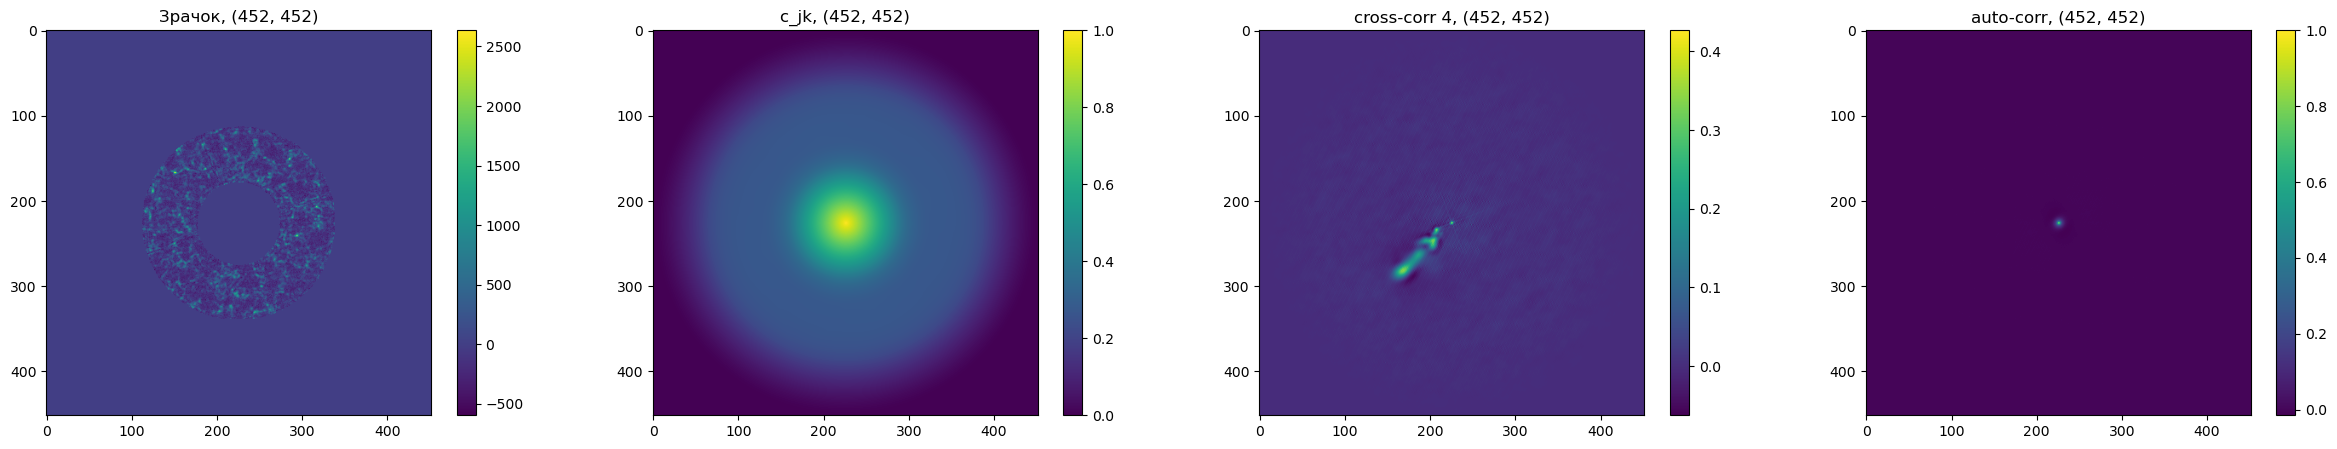

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from IPython.display import clear_output
from bisect import bisect_left

def take_closest(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0, 1
    if pos == len(myList):
        return -2, -1
    if pos != 0:
        before = myList[pos - 1]
        after = myList[pos]
        return np.argwhere(myList==after)[0][0], np.argwhere(myList==before)[0][0]

def c_jk(data):
    nx = data.shape[0] # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка)
    I0c = (data != 0) * int(1)
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx

def gamma_poly_se(X, Y, Vx, Vy, z):
    global cjk, t, a1, gammas, data, delta
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    res = gammas[take_closest(a1, z)[0]] + (z - a1[take_closest(a1, z)[0]]) * \
        ((gammas[take_closest(a1, z)[1]] - gammas[take_closest(a1, z)[0]])/ \
         (a1[take_closest(a1, z)[1]] - a1[take_closest(a1, z)[0]]))

    res = shift(res, (-Ypix, Xpix), order=1) 
    
    res = res * cjk
    
    k = np.max(data[data.shape[0]//2-int(Ypix)-1:data.shape[0]//2-int(Ypix)+2, 
                    data.shape[1]//2+int(Xpix)-1:data.shape[1]//2+int(Xpix)+2]) / np.max(res)
    res = res * k
    return res, k

# ----------- входные параметры
D = 2.5
latency = 4
sec_per_frame = 0.01
t = sec_per_frame * latency

# ---------- считывание зрачка и картины мерцаний
pupil = np.loadtxt('C:/astro/domecam/bigdata.gz')
data = np.loadtxt('C:/astro/domecam/bigdata_corr4.gz')
data0 = np.loadtxt('C:/astro/domecam/bigdata_corr0.gz')
pupil_pix = pupil.shape[0]//2 # Диаметр зрачка в пикселях

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

# ------------- c_jk
cjk, nx = c_jk(pupil)
f_scale = pupil_pix/(D*nx)
delta = D/pupil_pix 

# -------------- гаммы
gammas = np.load(f'C:/astro/domecam/gammas.npy')
print(gammas.shape)

# ------------------ распределение гамм
a1 = 3*np.logspace(2.824, 4, num=100, base=10)
a1[0]=2000

fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr 4, {data.shape}')

fig.colorbar(ax4.imshow(data0), ax=ax4)
ax4.grid(False)
ax4.set_title(f'auto-corr, {data0.shape}')

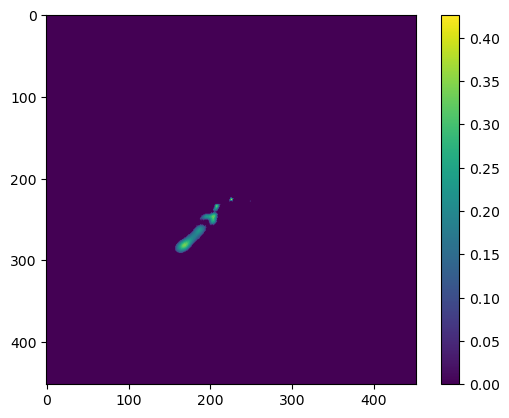

In [48]:
from skimage.filters import threshold_otsu
data2=data*(data>threshold_otsu(data))
plt.imshow(data2)
plt.colorbar()

In [64]:
def multi_speckle_fit(params=None, ydata=None):
    global xdata, sec_per_frame, latency, delta
    def speckle_fit(xcoord, ycoord, z_dist, ydata): # аппроксимация одного слоя
        k=30 # ! убрать это К и посмотртеь без него на результат
        def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
            x, y = M
            arr = np.zeros(x.shape)
            for i in range(len(args)//3):
                arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
#                 arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0]).ravel()
            return arr
        
        params = [(xcoord, ycoord, z_dist)] # подгонка типа ввода параметров под функцию
        p0 = [p for prms in params for p in prms]
        
        st=time.perf_counter()
        
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        t = sec_per_frame * latency
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
                
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]

        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)

        fit = np.zeros(X.shape) # результирующее изображение
        xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
        ydata = ydata.ravel()
        
        popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-3, ycoord-3, 2000],
                                                             [xcoord+3, ycoord+3, np.inf]]) 
#         popt, pcov = curve_fit(_g, xdata, ydata, p0)
        print(f'Fitted parametrs: {popt[0]:.2f} {popt[1]:.2f} {popt[2]}')
        k_coeff=[]
        for i in range(len(popt)//3):
            fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
#             fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])
            k_coeff.append(gamma_poly_se(X, Y, *popt[i*3:i*3+3])[1])

        print(f'Time: {time.perf_counter()-st:.4f}')
    
        t = sec_per_frame * latency
        Xpix = int(popt[0]*t/delta)
        Ypix = int(popt[1]*t/delta)
    
        return fit, Xpix, Ypix, k_coeff, popt[2], popt[0], popt[1]
    
    myParams = [p for prms in params for p in prms]
    res = np.zeros(data.shape)
    cr = data.shape[0]//2 # центр изображения
    Xc = []
    Yc = []
    t = sec_per_frame * latency

    for i in range(len(myParams)//3):
        print(f'Speckle fitting:', *myParams[i*3:i*3+3])
        fit, xcoord, ycoord, Cn2_fitted, zv, Vx, Vy = speckle_fit(*myParams[i*3:i*3+3], ydata)
        res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
            (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
#         res +=fit
        Xc.append(xcoord)
        Yc.append(ycoord)

        print(f'-Cn2: {Cn2_fitted[0]*1e-13}')
        print(f'-max fitted value: {np.max(fit):.2f}')
        print(f'-max initial value: {np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]):.2f}')
        print('')
    
    return res, Xc, Yc, Cn2_fitted[0]*1e-13, zv, Vx, Vy

Speckle fitting: 0 0 2000
Fitted parametrs: 0.00 0.00 2000.0000002
Time: 0.0974
-Cn2: 3.0444011075700618e-12
-max fitted value: 0.43
-max initial value: 0.43

Speckle fitting: -7.5 -7.5 18000
Fitted parametrs: -6.54 -6.21 22872.09938985405
Time: 0.3270
-Cn2: 4.427096463295298e-13
-max fitted value: 0.34
-max initial value: 0.34

Speckle fitting: -15 -15 26000
Fitted parametrs: -15.73 -15.31 36776.646209526414
Time: 0.4468
-Cn2: 6.439983263655384e-13
-max fitted value: 0.34
-max initial value: 0.34

 
Cn2: 6.439983263655384e-13
min value fit: -0.02715796597463928 coords: (278, 183)
max value fit: 0.43280200610492414 coords: (226, 226)
min value data: -0.06267354539534749 coords: (240, 199)
max value data: 0.4267005399870123 coords: (226, 226)
resid min: -0.24074041189720263 coords: (242, 208)
resid max: 0.3179615707395827



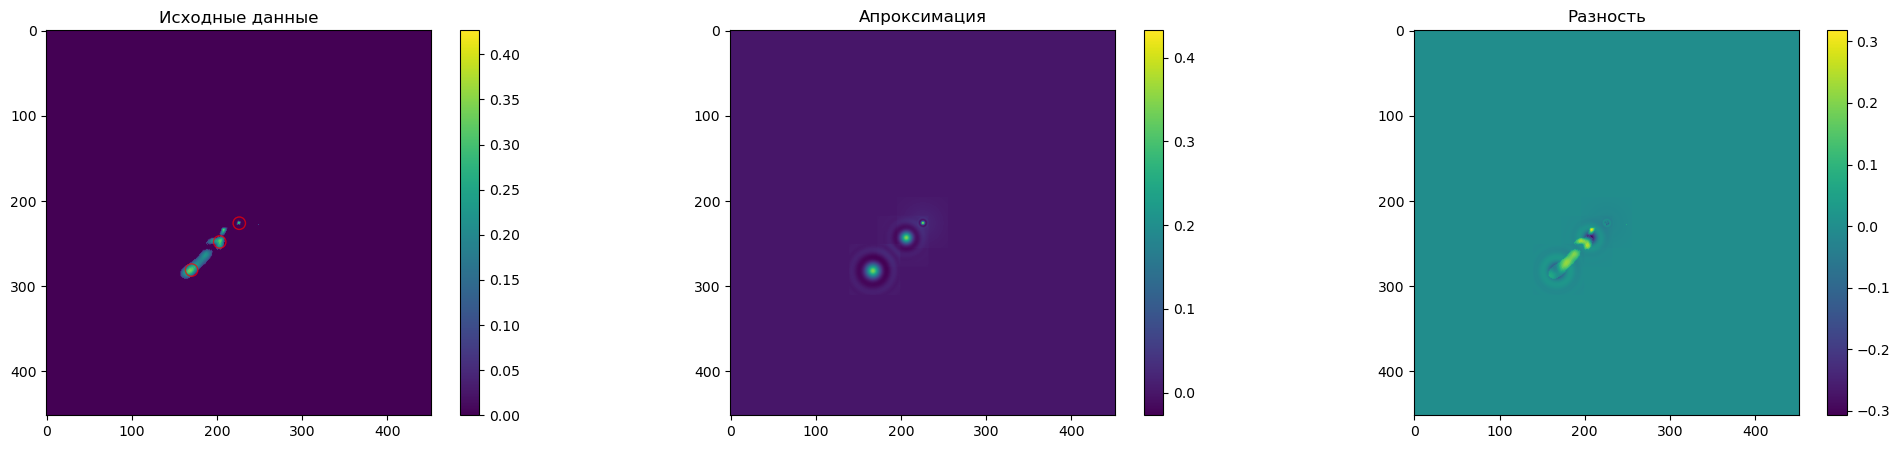

In [65]:
myParams = [( 0,   0, 2000),
            (-7.5, -7.5, 18000),
            (-15, -15, 26000)]

fit, speckle_x, speckle_y, Cn2_values, z, vx, vy = multi_speckle_fit(params=myParams, ydata=data2)

print(' ')
print('Cn2:', Cn2_values)
print('min value fit:', np.min(fit), 'coords:', np.unravel_index(np.argmin(fit), fit.shape))
print('max value fit:', np.max(fit), 'coords:', np.unravel_index(np.argmax(fit), fit.shape))
print('min value data:', np.min(data), 'coords:', np.unravel_index(np.argmin(data), data.shape))
print('max value data:', np.max(data), 'coords:', np.unravel_index(np.argmax(data), data.shape))
print('resid min:', np.min(data-fit), 'coords:', np.unravel_index(np.argmin(data-fit), (data-fit).shape))
print('resid max:', np.max(data-fit))

# ------------ Отрисовка ---------------------------
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
cr = data.shape[0]//2 # центр изображения

fig.colorbar(ax.imshow(data2), ax=ax)
ax.set_title('Исходные данные')
fig.colorbar(ax2.imshow(fit), ax=ax2)
ax2.set_title('Апроксимация')
fig.colorbar(ax3.imshow(data2-fit), ax=ax3)
ax3.set_title('Разность')
for i in range(len(speckle_x)):
    ax.scatter(cr+speckle_x[i], cr-speckle_y[i], alpha=0.7, s=80, facecolors='none', edgecolors='r')

print('')

C:\Users\miron\AppData\Local\Temp\ipykernel_11520\1999250716.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window=np.ones(dirty.shape, np.bool)


Speckle fitting: 0.0 0.0 2000
Fitted parametrs: 0.00 0.00 2000.0000002
Time: 0.0979
-Cn2: 3.0444011075700618e-12
-max fitted value: 0.43
-max initial value: 0.43

psf*gain: 0.04267005399870123
psf: 0.4267005399870123
Speckle fitting: 0.0 0.0 2000
Fitted parametrs: 0.00 0.00 2000.0000002
Time: 0.0922
-Cn2: 3.0444011075700618e-12
-max fitted value: 0.43
-max initial value: 0.43

psf*gain: 0.04267005399870123
psf: 0.4267005399870123
Speckle fitting: -15.763274336283187 -15.486725663716813 10000
Fitted parametrs: -15.84 -15.34 36534.70373223878
Time: 0.3745
-Cn2: 6.526657370600166e-13
-max fitted value: 0.34
-max initial value: 0.34

psf*gain: 0.034256663060336395
psf: 0.34256663060336395
Speckle fitting: 0.0 0.0 2000
Fitted parametrs: 0.00 0.00 2000.0000002
Time: 0.1278
-Cn2: 3.0444011075700618e-12
-max fitted value: 0.43
-max initial value: 0.43

psf*gain: 0.04267005399870123
psf: 0.4267005399870123
Speckle fitting: -6.084070796460177 -6.084070796460177 10000
Fitted parametrs: -6.54 -6.2

Fitted parametrs: -5.82 -5.53 4434.4253695333255
Time: 0.6908
-Cn2: 1.6308389224551473e-12
-max fitted value: 0.33
-max initial value: 0.34

psf*gain: 0.033228244059564725
psf: 0.33228244059564727
Speckle fitting: -14.380530973451327 -14.380530973451327 10000
Fitted parametrs: -14.41 -14.32 14729.969695844367
Time: 0.3631
-Cn2: 1.1214056184045173e-12
-max fitted value: 0.29
-max initial value: 0.32

psf*gain: 0.029397739301442256
psf: 0.29397739301442255
Speckle fitting: -10.785398230088495 -9.955752212389381 10000
Fitted parametrs: -10.76 -10.40 18318.522699325364
Time: 0.4632
-Cn2: 5.047636679548314e-13
-max fitted value: 0.23
-max initial value: 0.23

psf*gain: 0.022637947486250545
psf: 0.22637947486250545
Speckle fitting: -5.530973451327434 -3.31858407079646 10000
Fitted parametrs: -5.37 -3.32 10678.226391301134
Time: 0.1307
-Cn2: 5.213606858733076e-13
-max fitted value: 0.24
-max initial value: 0.34

psf*gain: 0.024023677662111116
psf: 0.24023677662111115
Speckle fitting: -5.80752

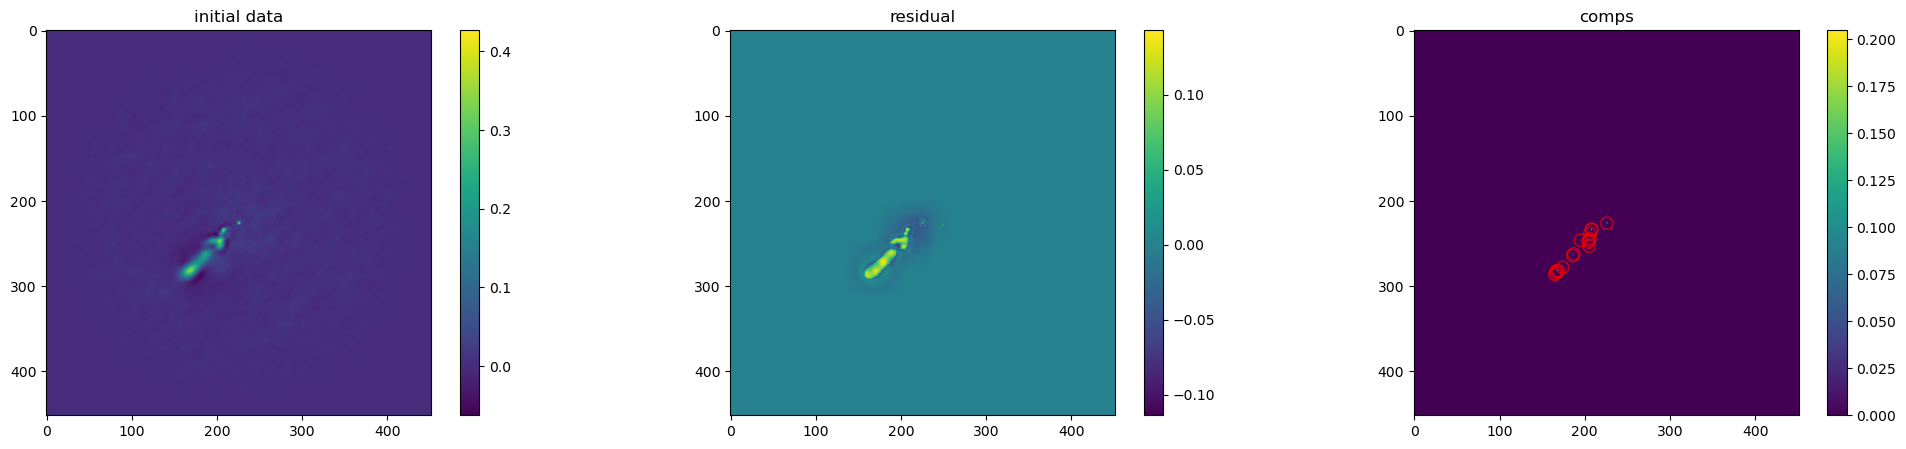

In [66]:
def CLEAN(dirty, gain, thresh, niter):
    global sec_per_frame, latency, delta
    """
    Hogbom clean, https://www.mrao.cam.ac.uk/~bn204/alma/python-clean.html

    :dirty: Изображение, подлежащее деконволюции
    :gain: Коэффициент усиления, т.е. доля самого яркого пикселя, которая удаляется на каждой итерации
    :thresh: Алгоритм прекращается при достижении максимального абсолютного отклонения остатка меньше этого значения
    :niter: Максимальное количество итераций, который необходимо провести, если пороговое значение "thresh" не достигнуто
    """
    comps=np.zeros(dirty.shape)
    res=np.array(dirty) 
    window=np.ones(dirty.shape, np.bool)
    
    tmp = 0
    Cn2 = []
    z = []
    vx = []
    vy = []

    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res[window]), res.shape) # fabs? # нахождение максимального значения
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        t = sec_per_frame * latency
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
     
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [(Vx, Vy, 2000)]
        else:
            myParams = [(Vx, Vy, 10000)]
            
        psf, speckle_x, speckle_y, Cn2v, zv, vxv, vyv = multi_speckle_fit(params=myParams, ydata=res)
        Cn2.append(Cn2v)
        z.append(zv)
        vx.append(vxv)
        vy.append(vyv)

        
        res -= psf*gain
#         print('psf*gain:', np.max(psf*gain))
#         print('psf:', np.max(psf))
    
        tmp+=1
#         if np.max(np.fabs(res)) < thresh: # мб это хороший варик, чтобы в минус не уходить
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total interations:', tmp)
    return comps, res, Cn2, z, vx, vy


# =============================================
comps, residual, Cn2, z, vx, vy = CLEAN(data2, 0.1, 0, 50)
# =============================================
lambda_=650*pow(10, -9) # нм
k = 2*np.pi/lambda_
r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
print(' ')
print('RMS:', np.mean((data - fit)**2))
print('sum Cn2:', np.sum(Cn2))
print('r0, sm:', 100*r0)
print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.colorbar(ax.imshow(data), ax=ax)
fig.colorbar(ax2.imshow(residual), ax=ax2)
fig.colorbar(ax3.imshow(comps), ax=ax3)
a_tmp = np.where(comps!=0)
for i in range(len(a_tmp[0])):
    ax3.scatter(a_tmp[1][i], a_tmp[0][i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
ax.set_title('initial data')
ax2.set_title('residual')
ax3.set_title('comps')
print('')

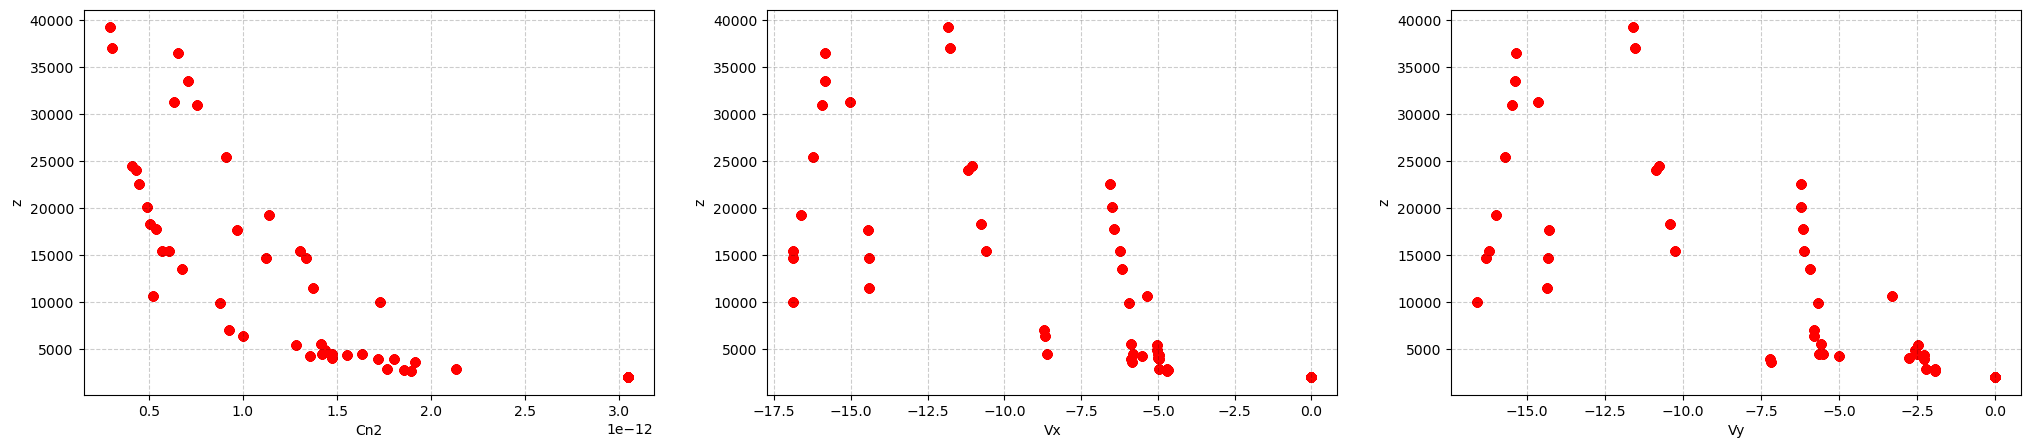

In [68]:
profile1 = np.stack((z, Cn2))
profile1 = profile1[:, profile1[0].argsort()]

profile2 = np.stack((z, vx))
profile2 = profile2[:, profile2[0].argsort()]

profile3 = np.stack((z, vy))
profile3 = profile3[:, profile3[0].argsort()]

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

for i in range(len(profile1[0])):
    ax.scatter(profile1[1], profile1[0], color='red')
    ax2.scatter(profile2[1], profile2[0], color='red')
    ax3.scatter(profile3[1], profile3[0], color='red')
    
ax.set_xlabel('Cn2')
ax.set_ylabel('z')
ax2.set_xlabel('Vx')
ax2.set_ylabel('z')
ax3.set_xlabel('Vy')
ax3.set_ylabel('z')
ax.grid(color = 'black', linestyle='--', alpha = 0.2)
ax2.grid(color = 'black', linestyle='--', alpha = 0.2)
ax3.grid(color = 'black', linestyle='--', alpha = 0.2)

min value fit: -0.11380120397544702 coords: (228, 226)
max value fit: 0.14286286113789734 coords: (233, 208)
centr value: 0.10655311306631096


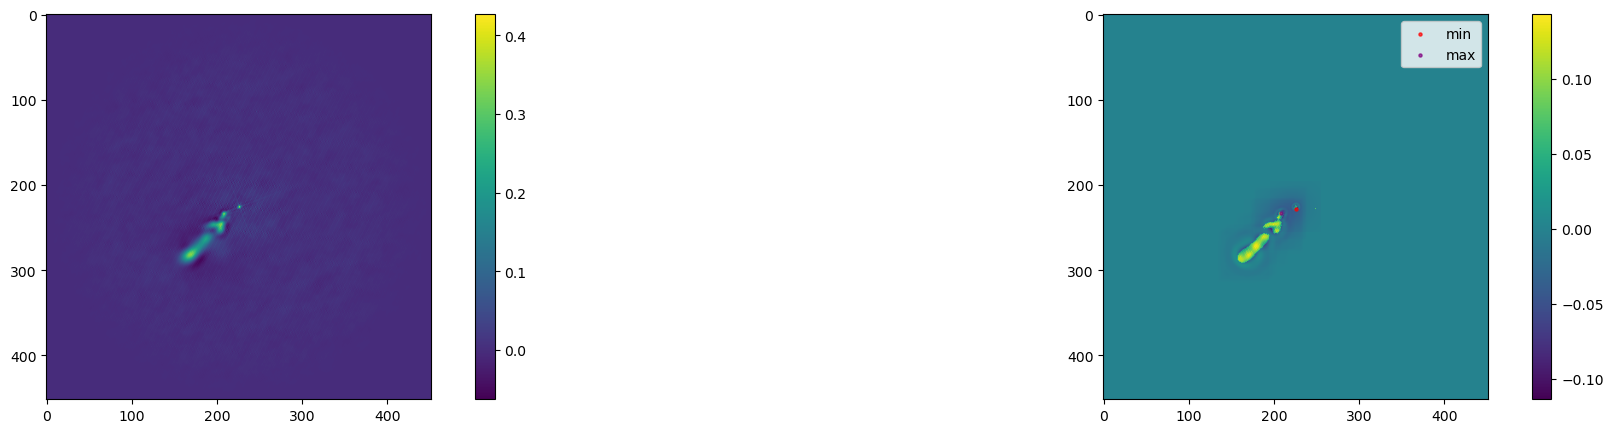

In [67]:
fig, (ax, ax3) = plt.subplots(1, 2, figsize=(25, 5))

fig.colorbar(ax.imshow(data), ax=ax)
fig.colorbar(ax3.imshow(residual), ax=ax3)
ax3.scatter(np.unravel_index(np.argmin(residual), residual.shape)[1], 
            np.unravel_index(np.argmin(residual), residual.shape)[0], color='red', alpha=0.7, s=5, label='min')
ax3.scatter(np.unravel_index(np.argmax(residual), residual.shape)[1],
            np.unravel_index(np.argmax(residual), residual.shape)[0], color='purple', alpha=0.7, s=5, label='max')
ax3.legend()

print('min value fit:', np.min(residual), 'coords:', np.unravel_index(np.argmin(residual), residual.shape))
print('max value fit:', np.max(residual), 'coords:', np.unravel_index(np.argmax(residual), residual.shape))
print('centr value:', residual[226, 226])
# fig.savefig('C:/astro/domecam/profiles1_2.png', bbox_inches='tight')

In [ ]:
# клин подходит не оч на большом кол-ве итерраций, т.к. он принимает остаточные маленькие пики за новые слои, в то время как
# они не принадлежат других слоям, а являются всего лишь остатками предыдуших


# 1. попробовать передать в керв-фит сразу все начальные приближения
# 2. что если сгенирить сигму (кадр ошибок) используя галфит или другой сторонний софт?
# 3. что если гамму вообще научиться сплющивать и поворачивать, чтобы подгонять ее под сам пик
# 4. что если к Оцу применять гамма-коррекцию, чтобы не так жестко обрезал